In [14]:
import json
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import layers, Model, mixed_precision
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
mixed_precision.set_global_policy('float32')

In [4]:
ROOT = Path("../")
TUSIMPLE_ROOT = ROOT / "Data/TUSimple"
TRAINING_ROOT = TUSIMPLE_ROOT / "train_set"
TRAINING_MASK_ROOT = TRAINING_ROOT / "masks"
TRAINING_LABEL_FILES = [
    TRAINING_ROOT / "label_data_0313.json",
    TRAINING_ROOT / "label_data_0531.json",
    TRAINING_ROOT / "label_data_0601.json",
]
TESTING_ROOT = TUSIMPLE_ROOT / "test_set"
TESTING_MASK_ROOT = TESTING_ROOT / "masks"
TESTING_LABELS = TESTING_ROOT / "test_label.json"
MODEL_ROOT = ROOT / "Models"
IMG_WIDTH = 640
IMG_HEIGHT = 384
BATCH_SIZE = 8
SEED = 1337
AUTOTUNE = tf.data.AUTOTUNE
BCE = tf.keras.losses.BinaryCrossentropy()

In [5]:
def render(image, win_name="MyWindow"):
    cv2.imshow(win_name, image)
    cv2.waitKey(0)
    cv2.destroyWindow(win_name)

In [6]:
def make_mask(rec, mode):
    if mode=="training":
        image_path = TRAINING_ROOT / rec["raw_file"]
    elif mode=="testing":
        image_path = TESTING_ROOT / rec["raw_file"]
    else:
        raise ValueError("invalid mode")
    image = cv2.imread(image_path)
    mask = np.zeros(image.shape[:2])
    h_pts = rec["h_samples"]
    lines = []
    for x_pts in rec["lanes"]:
        line_pts = np.array([(x, y) for x, y in zip(x_pts, h_pts) if x >= 0], dtype=np.int32).reshape(-1, 1, 2)
        lines.append(line_pts)
    cv2.polylines(mask, lines, False, 1, 10, lineType=cv2.LINE_AA)
    return image, mask

In [7]:
def save_all_masks():
    for lf in TRAINING_LABEL_FILES:
        with open(lf, "r") as f:
            for line in f:
                rec = json.loads(line)
                mask_path = TRAINING_MASK_ROOT / Path(rec["raw_file"]).with_suffix(".png")
                _, mask = make_mask(rec, "training")
                mask_path.parent.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(mask_path), mask)
    with open(TESTING_LABELS, "r") as f:
        for line in f:
            rec = json.loads(line)
            mask_path = TESTING_MASK_ROOT / Path(rec["raw_file"]).with_suffix(".png")
            _, mask = make_mask(rec, "testing")
            mask_path.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(mask_path), mask)

In [8]:
# save_all_masks()

In [8]:
def mask_path_from_raw(raw, mode):
    if mode=="training":
        mask_path = TRAINING_MASK_ROOT / Path(raw).with_suffix(".png")
    elif mode=="testing":
        mask_path = TESTING_MASK_ROOT / Path(raw).with_suffix(".png")
    return mask_path

In [9]:
def load_pair(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image  = preprocess_input(tf.cast(image, tf.float32))

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method="nearest")

    return image, mask

In [10]:
def make_ds(images, masks, training=True):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if training:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_pair, num_parallel_calls=AUTOTUNE
          ).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

In [29]:
training_image_paths = []
training_mask_paths = []

for lf in TRAINING_LABEL_FILES:
    with open(lf, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            ip = TRAINING_ROOT / rec["raw_file"]
            mp = mask_path_from_raw(rec["raw_file"], "training")
            if ip.exists() and mp.exists():
                training_image_paths.append(str(ip))
                training_mask_paths.append(str(mp))

__image_paths = []
__mask_paths = []

with open(TESTING_LABELS, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        ip = TESTING_ROOT / rec["raw_file"]
        mp = mask_path_from_raw(rec["raw_file"], "testing")
        if ip.exists() and mp.exists():
            __image_paths.append(str(ip))
            __mask_paths.append(str(mp))

validation_image_paths = __image_paths[:400]
validation_mask_paths = __mask_paths[:400]
testing_image_paths = __image_paths[400:]
testing_mask_paths = __mask_paths[400:]

training_ds = make_ds(training_image_paths, training_mask_paths, True).map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
validation_ds = make_ds(validation_image_paths, validation_mask_paths, True).map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
testing_ds = make_ds(testing_image_paths, testing_mask_paths, False).map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [11]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    input = layers.Input(input_shape)

    encoder = tf.keras.applications.MobileNetV2(input_tensor=input, include_top=False, weights="imagenet")

    # skip levels
    s1 = encoder.get_layer("block_3_expand_relu").output       # 1/4
    s2 = encoder.get_layer("block_6_expand_relu").output       # 1/8
    s3 = encoder.get_layer("block_13_expand_relu").output      # 1/16
    bottleneck  = encoder.get_layer("block_16_project").output # 1/32

    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(bottleneck)  # 1/16
    x = layers.Concatenate()([x, s3])
    x = conv_block(x, 256)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)  # 1/8
    x = layers.Concatenate()([x, s2])
    x = conv_block(x, 128)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)   # 1/4
    x = layers.Concatenate()([x, s1])
    x = conv_block(x, 64)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)   # 1/2
    x = conv_block(x, 32)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same")(x)   # 1/1
    x = conv_block(x, 16)

    out = layers.Conv2D(1, 1, activation="sigmoid")(x)  # binary mask
    return Model(input, out)


In [12]:
def dice_loss(y_true, y_pred, smooth=.001):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    denom = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return 1.0 - dice

def bce_dice_loss(y_true, y_pred):
    return BCE(y_true, y_pred) + dice_loss(y_true, y_pred)

In [13]:
class BatchIoU(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name="bin_iou", **kw):
        super().__init__(name=name, **kw)
        self.th = threshold
        self.inter = self.add_weight("inter", initializer="zeros")
        self.union = self.add_weight("union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true > 0.5, tf.float32)       # ensure {0,1}
        y_pred = tf.cast(y_pred > self.th, tf.float32)   # threshold probs
        inter = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
        self.inter.assign_add(inter)
        self.union.assign_add(union)

    def result(self):
        return (self.inter + 1e-7) / (self.union + 1e-7)

    def reset_states(self):
        self.inter.assign(0.0)
        self.union.assign(0.0)

In [68]:
lane_iou = BatchIoU(name="lane_iou")

MODEL_ROOT.mkdir(parents=True, exist_ok=True)
checkpoint_path = MODEL_ROOT / "lane_seg_best.weights.h5"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_lane_iou", mode="max",
        save_best_only=True, save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_lane_iou", mode="max", patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_lane_iou", mode="max", factor=0.5, patience=4, min_lr=1e-6
    ),
]

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=bce_dice_loss,
              metrics=[lane_iou])

In [69]:
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
454/454 [==============================] - ETA: 0s - loss: 0.6952 - lane_iou: 0.4230

c:\Users\bpcur\anaconda3\envs\lane_det_GPU\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric BatchIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


454/454 [==============================] - 588s 1s/step - loss: 0.6952 - lane_iou: 0.4230 - val_loss: 0.4886 - val_lane_iou: 0.4749 - lr: 0.0010
Epoch 2/50
454/454 [==============================] - 579s 1s/step - loss: 0.4069 - lane_iou: 0.5248 - val_loss: 0.4215 - val_lane_iou: 0.4999 - lr: 0.0010
Epoch 3/50
454/454 [==============================] - 580s 1s/step - loss: 0.3775 - lane_iou: 0.5405 - val_loss: 0.6519 - val_lane_iou: 0.2988 - lr: 0.0010
Epoch 4/50
454/454 [==============================] - 581s 1s/step - loss: 0.3625 - lane_iou: 0.5524 - val_loss: 0.3958 - val_lane_iou: 0.5251 - lr: 0.0010
Epoch 5/50
454/454 [==============================] - 580s 1s/step - loss: 0.3518 - lane_iou: 0.5617 - val_loss: 0.3496 - val_lane_iou: 0.5720 - lr: 0.0010
Epoch 6/50
454/454 [==============================] - 579s 1s/step - loss: 0.3418 - lane_iou: 0.5708 - val_loss: 0.3428 - val_lane_iou: 0.5689 - lr: 0.0010
Epoch 7/50
454/454 [==============================] - 580s 1s/step - loss: 

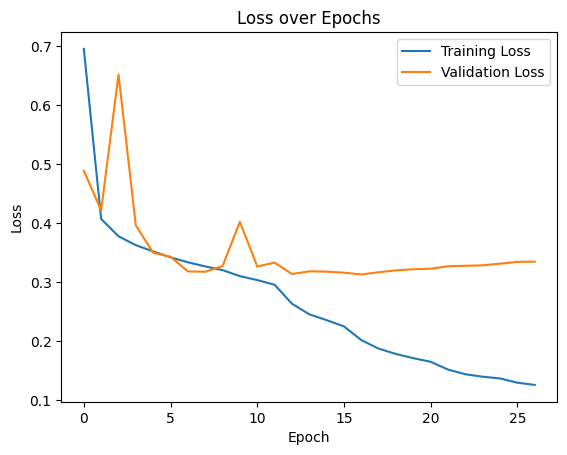

In [71]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

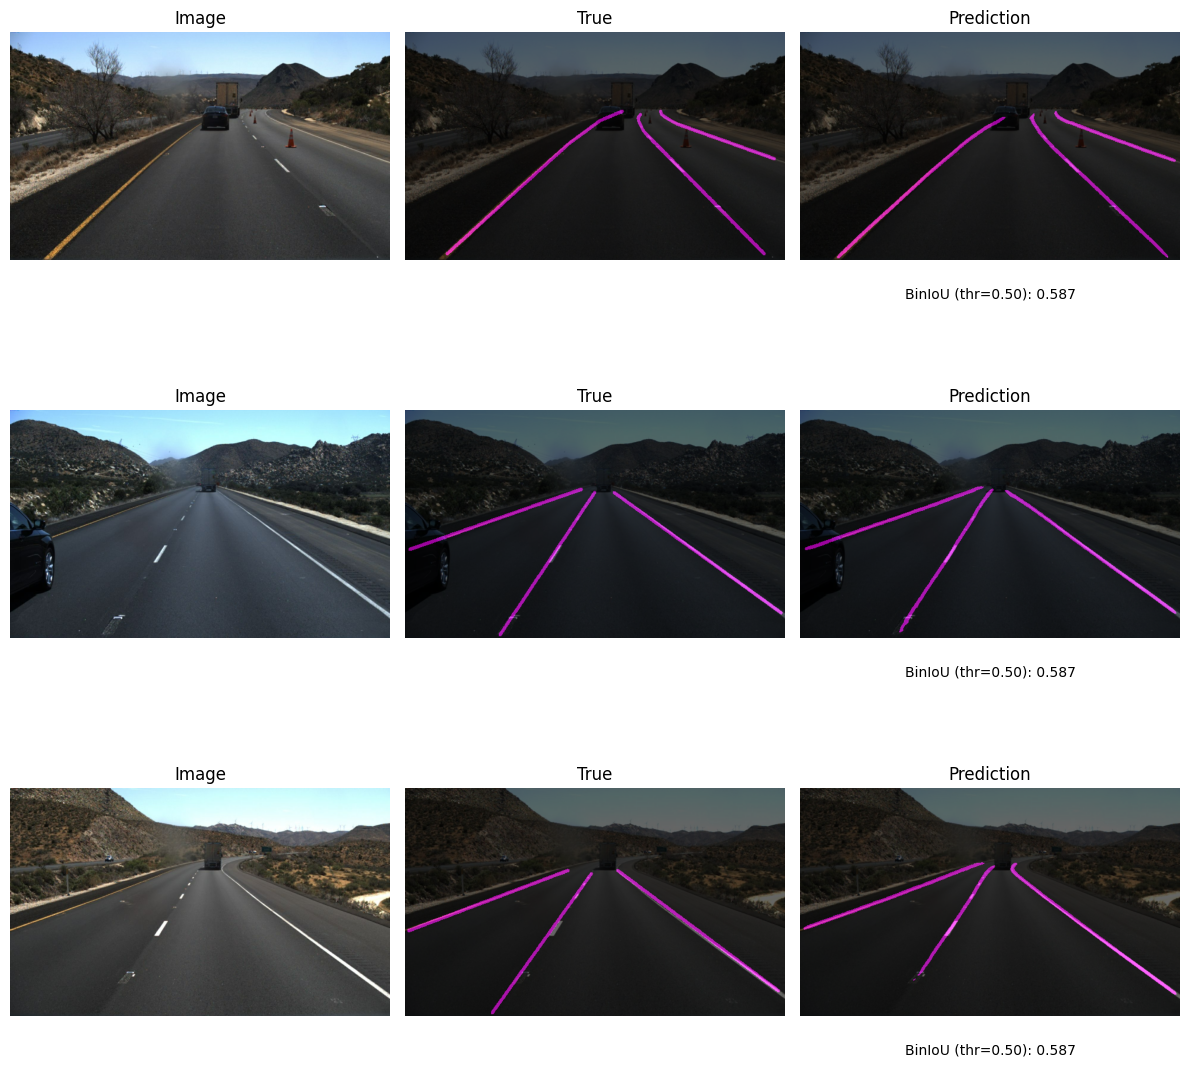

In [ ]:
def show_predictions(ds, n=3, thr=0.5):
    batch = next(iter(ds))
    imgs, masks = batch
    preds = model.predict(imgs, verbose=0)
    preds = (preds > thr).astype(np.uint8)

    n = min(n, imgs.shape[0])
    plt.figure(figsize=(12, 4*n))
    for i in range(n):
        img  = imgs[i].numpy()
        gt   = masks[i].numpy().squeeze()
        pr   = preds[i].squeeze()

        img = (img + 1) / 2

        overlay_true = img.copy()
        color_true = np.zeros_like(img)
        color_true[gt>0] = (1.0, 0.0, 1.0)
        overlay_true = 0.4*img + .6*color_true

        overlay_pr = img.copy()
        color_pr = np.zeros_like(img)
        color_pr[pr>0] = (1.0, 0.0, 1.0)
        overlay_pr = 0.4*img + .6*color_pr

        IoU = lane_iou(gt, pr)

        plt.subplot(n,3,3*i+1); plt.imshow(img);  plt.title("Image");   plt.axis("off")
        plt.subplot(n,3,3*i+2); plt.imshow(overlay_true);  plt.title("True"); plt.axis("off")
        ax = plt.subplot(n,3,3*i+3); plt.imshow(overlay_pr);  plt.title("Prediction");    plt.axis("off");  ax.text(0.5, -0.12, f"BinIoU (thr={thr:.2f}): {IoU:.3f}",
                 ha="center", va="top", transform=ax.transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

show_predictions(testing_ds, n=3)

In [84]:
test_results = model.evaluate(testing_ds, return_dict=True, verbose=1)
print(test_results)

c:\Users\bpcur\anaconda3\envs\lane_det_GPU\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric BatchIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


298/298 [==============================] - 91s 304ms/step - loss: 0.3479 - lane_iou: 0.5628
{'loss': 0.3479458689689636, 'lane_iou': 0.5627517104148865}


Best IoU: 0.5668 at threshold=0.12


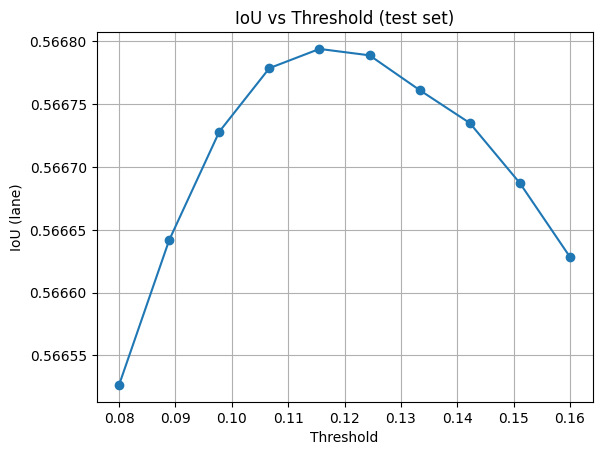

In [88]:
def sweep_thresholds(model, ds, thresholds=np.linspace(0.2, 0.8, 13)):
    thresholds = np.asarray(list(thresholds), dtype=np.float32)
    T = len(thresholds)

    TP = np.zeros(T, dtype=np.float64)
    FP = np.zeros(T, dtype=np.float64)
    FN = np.zeros(T, dtype=np.float64)

    for imgs, masks in ds:  # masks expected in {0,1}, shape (B,H,W,1)
        probs = model(imgs, training=False).numpy().squeeze(-1)  # (B,H,W)
        gt    = (masks.numpy().squeeze(-1) > 0.5)                # bool

        # For each threshold, compute tp/fp/fn incrementally (vectorized per batch)
        for i, th in enumerate(thresholds):
            pred = probs > th                                     # bool
            tp = np.logical_and(pred, gt).sum()
            fp = np.logical_and(pred, ~gt).sum()
            fn = np.logical_and(~pred, gt).sum()
            TP[i] += tp; FP[i] += fp; FN[i] += fn

    iou = TP / (TP + FP + FN + 1e-9)
    best_idx = int(np.argmax(iou))
    return {
        "thresholds": thresholds,
        "iou": iou,
        "best_threshold": float(thresholds[best_idx]),
        "best_iou": float(iou[best_idx]),
        "TP": TP, "FP": FP, "FN": FN
    }

# Run the sweep
res = sweep_thresholds(model, testing_ds, thresholds=np.linspace(0.08, 0.16, 10))
print(f"Best IoU: {res['best_iou']:.4f} at threshold={res['best_threshold']:.2f}")

# Plot
plt.plot(res["thresholds"], res["iou"], marker="o")
plt.xlabel("Threshold"); plt.ylabel("IoU (lane)")
plt.title("IoU vs Threshold (test set)")
plt.grid(True); plt.show()

In [22]:
test_img = plt.imread(TESTING_ROOT / "clips" / "0530" / "1492626047222176976_0" / "1.jpg")
test_img = tf.image.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
test_img = preprocess_input(tf.cast(test_img, tf.float32))
test_img = np.fliplr(test_img)

In [23]:
test_mask = model.predict(tf.expand_dims(test_img, 0))

1/1 [==============================] - 10s 10s/step


In [24]:
prob = np.squeeze(test_mask[0], axis=-1)
to_show = (test_img + 1) / 2.0
pred = prob > 0.12
color = np.zeros_like(to_show)
color[pred] = (1.0, 0.0, 1.0)
overlay = 0.4*to_show + 0.6*color

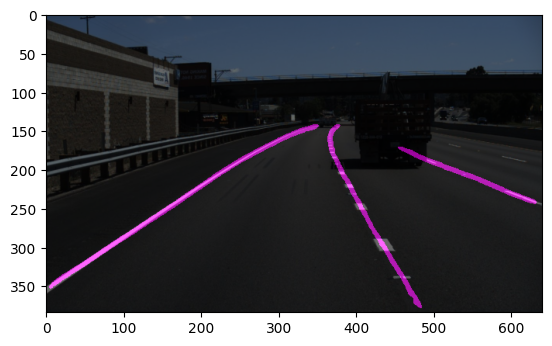

In [25]:
plt.imshow(overlay)

In [39]:
coords = np.where(pred > 0)

In [40]:
x_coords, y_coords = coords[0], coords[1]

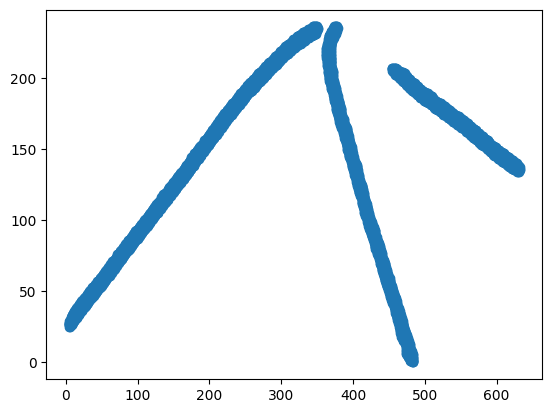

In [46]:
plt.scatter(y_coords, np.max(x_coords)-x_coords)

In [48]:
from sklearn.cluster import DBSCAN

In [70]:
dbscan = DBSCAN(eps=5, min_samples=3)

In [71]:
X = list(zip(coords[0], coords[1]))

In [72]:
dbscan.fit(X)

,eps,5
,min_samples,3
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [73]:
labels = dbscan.labels_

In [76]:
polys = []
for group in set(labels):
    x_data = coords[0][np.where(labels==group)]
    y_data = coords[1][np.where(labels==group)]
    poly = np.polyfit(y_data, x_data, deg=3)
    polys.append(poly)

In [106]:
y = np.linspace(0, IMG_WIDTH)

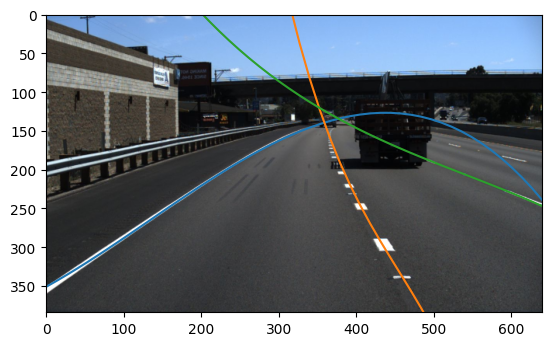

In [111]:
plt.ylim(384, 0)
plt.plot(y, polys[0][0]*y**3 + polys[0][1]*y**2 + polys[0][2]*y + polys[0][3])
plt.plot(y, polys[1][0]*y**3 + polys[1][1]*y**2 + polys[1][2]*y + polys[1][3])
plt.plot(y, polys[2][0]*y**3 + polys[2][1]*y**2 + polys[2][2]*y + polys[2][3])
plt.imshow(to_show)